In [1]:
import pandas as pd
import utils
import warnings
import os
import skimage.util
import numpy as np
import matplotlib.pyplot as plt
import utils

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
channels = ["DNA", "AGP", "Mito", "ER", "RNA"]
channel_perturbation_df = pd.DataFrame()
overwrite = False

### ORF

In [3]:
orf_channel_wise_df = pd.read_parquet('input/orf_feat_pert_pval_mwu.parquet')
orf_channel_wise_df.shape

(3636, 15106)

Identify features names from the channels of interest

In [4]:
feature_name_df = pd.DataFrame()

for feature_name in orf_channel_wise_df.Feature.to_list():
    feature_name_df = pd.concat(
        [feature_name_df, pd.DataFrame(utils.parse_cp_features(feature_name), index=[0])], ignore_index=True
    )

In [5]:
query_string = " or ".join(f"channel == '{channel}'" for channel in channels)
print(query_string)

channel == 'DNA' or channel == 'AGP' or channel == 'Mito' or channel == 'ER' or channel == 'RNA'


In [6]:
feature_name_df = feature_name_df.query(query_string)
feature_names = feature_name_df.feature.to_list()

Remove features not belonging to the channels of interest

In [7]:
orf_channel_wise_df = orf_channel_wise_df.query(f"Feature in @feature_names")
orf_channel_wise_df.shape

(3005, 15106)

Stack the dataframe

In [8]:
orf_channel_wise_df = (
    orf_channel_wise_df.set_index("Feature")
    .stack()
    .reset_index()
    .rename(columns={"level_1": "Metadata_JCP2022", 0: "pval"})
    .query("pval < 0.05")
)

orf_channel_wise_df = (
    orf_channel_wise_df.groupby("Metadata_JCP2022").Feature.apply(list).reset_index()
)

orf_channel_wise_df.head()

,Metadata_JCP2022,Feature
0,JCP2022_900002,"[Cells_Granularity_2_Mito, Cells_Granularity_3..."
1,JCP2022_900003,"[Cells_Granularity_15_AGP, Cells_Granularity_1..."
2,JCP2022_900004,"[Cells_Granularity_13_DNA, Cells_Granularity_1..."
3,JCP2022_900005,"[Cells_Granularity_11_AGP, Cells_Granularity_1..."
4,JCP2022_900006,"[Cells_Granularity_10_RNA, Cells_Granularity_1..."


Count the number of features in each channel that is significantly different from the negative control.

In [9]:
for channel in channels:
    orf_channel_wise_df = orf_channel_wise_df.assign(
        count=lambda x: x.Feature.apply(
            lambda y: sum([1 if channel in i else 0 for i in y]) 
        )
    ).rename(columns={"count": f"{channel}_count"})

orf_channel_wise_df.head()

,Metadata_JCP2022,Feature,DNA_count,AGP_count,Mito_count,ER_count,RNA_count
0,JCP2022_900002,"[Cells_Granularity_2_Mito, Cells_Granularity_3...",4,0,99,5,1
1,JCP2022_900003,"[Cells_Granularity_15_AGP, Cells_Granularity_1...",21,144,3,46,36
2,JCP2022_900004,"[Cells_Granularity_13_DNA, Cells_Granularity_1...",43,13,12,39,7
3,JCP2022_900005,"[Cells_Granularity_11_AGP, Cells_Granularity_1...",169,63,42,9,36
4,JCP2022_900006,"[Cells_Granularity_10_RNA, Cells_Granularity_1...",268,265,163,151,35


Find the Metadata_JCP2022 with the highest number of significantly different features in each channel.

In [10]:
for channel in channels:
    perturbation = (
        orf_channel_wise_df.sort_values(by=f"{channel}_count", ascending=False)
        .head(1)
        .Metadata_JCP2022.values[0]
    )
    channel_perturbation_df = pd.concat(
        [
            channel_perturbation_df,
            pd.DataFrame(
                {"channel": channel, "Metadata_JCP2022": perturbation, "modality": "ORF"},
                index=[0],
            ),
        ],
        ignore_index=True,
    )

In [11]:
channel_perturbation_df.head()

,channel,Metadata_JCP2022,modality
0,DNA,JCP2022_903350,ORF
1,AGP,JCP2022_901975,ORF
2,Mito,JCP2022_913973,ORF
3,ER,JCP2022_902345,ORF
4,RNA,JCP2022_901975,ORF


## CRISPR

In [12]:
crispr_channel_wise_df = pd.read_parquet('input/crispr_feat_pert_pval_mwu.parquet')
crispr_channel_wise_df.shape

(3651, 7963)

Identify features names from the channels of interest

In [13]:
feature_name_df = pd.DataFrame()

for feature_name in crispr_channel_wise_df.Feature.to_list():
    feature_name_df = pd.concat(
        [feature_name_df, pd.DataFrame(utils.parse_cp_features(feature_name), index=[0])], ignore_index=True
    )

In [14]:
feature_name_df = feature_name_df.query(query_string)
feature_names = feature_name_df.feature.to_list()

Remove features not belonging to the channels of interest

In [15]:
cripsr_channel_wise_df = crispr_channel_wise_df.query(f"Feature in @feature_names")
crispr_channel_wise_df.shape

(3651, 7963)

Stack the dataframe

In [16]:
crispr_channel_wise_df = (
    crispr_channel_wise_df.set_index("Feature")
    .stack()
    .reset_index()
    .rename(columns={"level_1": "Metadata_JCP2022", 0: "pval"})
    .query("pval < 0.05")
)

crispr_channel_wise_df = (
    crispr_channel_wise_df.groupby("Metadata_JCP2022").Feature.apply(list).reset_index()
)

crispr_channel_wise_df.head()

,Metadata_JCP2022,Feature
0,JCP2022_800003,"[Cells_AreaShape_Area, Cells_AreaShape_Boundin..."
1,JCP2022_800004,"[Cells_AreaShape_Area, Cells_AreaShape_Boundin..."
2,JCP2022_800005,"[Cells_AreaShape_BoundingBoxMaximum_Y, Cells_A..."
3,JCP2022_800006,"[Cells_AreaShape_Area, Cells_AreaShape_Boundin..."
4,JCP2022_800007,"[Cells_AreaShape_Area, Cells_AreaShape_Boundin..."


Count the number of features in each channel that is significantly different from the negative control.

In [17]:
for channel in channels:
    crispr_channel_wise_df = crispr_channel_wise_df.assign(
        count=lambda x: x.Feature.apply(
            lambda y: sum([1 if channel in i else 0 for i in y]) 
        )
    ).rename(columns={"count": f"{channel}_count"})

crispr_channel_wise_df.head()

,Metadata_JCP2022,Feature,DNA_count,AGP_count,Mito_count,ER_count,RNA_count
0,JCP2022_800003,"[Cells_AreaShape_Area, Cells_AreaShape_Boundin...",406,225,436,513,437
1,JCP2022_800004,"[Cells_AreaShape_Area, Cells_AreaShape_Boundin...",100,252,259,274,269
2,JCP2022_800005,"[Cells_AreaShape_BoundingBoxMaximum_Y, Cells_A...",152,319,352,259,302
3,JCP2022_800006,"[Cells_AreaShape_Area, Cells_AreaShape_Boundin...",301,219,299,266,322
4,JCP2022_800007,"[Cells_AreaShape_Area, Cells_AreaShape_Boundin...",145,101,421,419,369


Find the Metadata_JCP2022 with the highest number of significantly different features in each channel

In [18]:
for channel in channels:
    perturbation = (
        crispr_channel_wise_df.sort_values(by=f"{channel}_count", ascending=False)
        .head(1)
        .Metadata_JCP2022.values[0]
    )
    channel_perturbation_df = pd.concat(
        [
            channel_perturbation_df,
            pd.DataFrame(
                {"channel": channel, "Metadata_JCP2022": perturbation, "modality": "CRISPR"},
                index=[0],
            ),
        ],
        ignore_index=True,
    )

channel_perturbation_df["pert_type"] = "trt"

In [19]:
channel_perturbation_df

,channel,Metadata_JCP2022,modality,pert_type
0,DNA,JCP2022_903350,ORF,trt
1,AGP,JCP2022_901975,ORF,trt
2,Mito,JCP2022_913973,ORF,trt
3,ER,JCP2022_902345,ORF,trt
4,RNA,JCP2022_901975,ORF,trt
5,DNA,JCP2022_805617,CRISPR,trt
6,AGP,JCP2022_802285,CRISPR,trt
7,Mito,JCP2022_803245,CRISPR,trt
8,ER,JCP2022_807822,CRISPR,trt
9,RNA,JCP2022_807822,CRISPR,trt


Choose one negative control for ORF and CRISPR

In [20]:
orf_metadata_df = pd.read_csv('../datasets/metadata/orf.csv.gz').query("Metadata_pert_type=='negcon'")
orf_metadata_df.head()

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type
15137,JCP2022_915128,ccsbBroad304_99985,ORFC00001.1_TRC304.1,pLX_304,BFP.1,BFP,BFP,CONTROL,Hahn Lab BFP,99.5,717.0,negcon
15138,JCP2022_915129,ccsbBroad304_99988,ORFC00002.1_TRC304.1,pLX_304,HcRed.1,HcRed,HcRed,CONTROL,NaN,NaN,824.0,negcon
15139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,1650.0,negcon
15140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,3204.0,negcon


In [21]:
crispr_metadata_df = pd.read_csv('../datasets/metadata/crispr.csv.gz')
crispr_metadata_df.head()

,Metadata_JCP2022,Metadata_NCBI_Gene_ID,Metadata_Symbol
0,JCP2022_800001,NaN,no-guide
1,JCP2022_800002,NaN,non-targeting
2,JCP2022_800003,2.0,A2M
3,JCP2022_800004,127550.0,A3GALT2
4,JCP2022_800005,53947.0,A4GALT


Choosing Luciferase for ORF and non-targeting guide for CRISPR

In [22]:
negcon_df = pd.DataFrame(
    {
        "channel": channels + channels,
        "modality": ["ORF" for _ in range(len(channels))]
        + ["CRISPR" for _ in range(len(channels))],
        "Metadata_JCP2022": ["JCP2022_915130" for _ in range(len(channels))]
        + ["JCP2022_800002" for _ in range(len(channels))],
        "pert_type": ["negcon" for _ in range(len(channels)*2)]
    },
    index=[_ for _ in range(len(channels) * 2)],
)

channel_perturbation_df = pd.concat(
    [channel_perturbation_df, negcon_df], ignore_index=True
)
channel_perturbation_df

,channel,Metadata_JCP2022,modality,pert_type
0,DNA,JCP2022_903350,ORF,trt
1,AGP,JCP2022_901975,ORF,trt
2,Mito,JCP2022_913973,ORF,trt
3,ER,JCP2022_902345,ORF,trt
4,RNA,JCP2022_901975,ORF,trt
5,DNA,JCP2022_805617,CRISPR,trt
6,AGP,JCP2022_802285,CRISPR,trt
7,Mito,JCP2022_803245,CRISPR,trt
8,ER,JCP2022_807822,CRISPR,trt
9,RNA,JCP2022_807822,CRISPR,trt


Select one well randomly for each perturbation

In [23]:
well_df = pd.read_csv("../datasets/metadata/well.csv.gz")

wells_chosen_df = pd.DataFrame()

for perturbation in channel_perturbation_df.Metadata_JCP2022.unique():
    df = well_df.query("Metadata_JCP2022 == @perturbation")
    df = df.sample(n=1, random_state=12527).reset_index(drop=True)
    wells_chosen_df = pd.concat([wells_chosen_df, df], ignore_index=True)

channel_perturbation_df = channel_perturbation_df.merge(
    wells_chosen_df, on="Metadata_JCP2022", how="left"
)

channel_perturbation_df


,channel,Metadata_JCP2022,modality,pert_type,Metadata_Source,Metadata_Plate,Metadata_Well
0,DNA,JCP2022_903350,ORF,trt,source_4,BR00123629,O08
1,AGP,JCP2022_901975,ORF,trt,source_4,BR00125179,B07
2,Mito,JCP2022_913973,ORF,trt,source_4,BR00125174,I15
3,ER,JCP2022_902345,ORF,trt,source_4,BR00123530,H17
4,RNA,JCP2022_901975,ORF,trt,source_4,BR00125179,B07
5,DNA,JCP2022_805617,CRISPR,trt,source_13,CP-CC9-R4-19,E17
6,AGP,JCP2022_802285,CRISPR,trt,source_13,CP-CC9-R5-27,F17
7,Mito,JCP2022_803245,CRISPR,trt,source_13,CP-CC9-R5-08,P12
8,ER,JCP2022_807822,CRISPR,trt,source_13,CP-CC9-R5-22,C08
9,RNA,JCP2022_807822,CRISPR,trt,source_13,CP-CC9-R5-22,C08


Add Gene symbol names to the metadata

In [24]:
orf_metadata_df = pd.read_csv("../00.download-and-process-annotations/output/orf_metadata.tsv.gz", sep='\t', usecols=["Metadata_JCP2022", "Metadata_Symbol"])
crispr_metadata_df = pd.read_csv("../00.download-and-process-annotations/output/crispr_metadata.tsv.gz", sep='\t', usecols=["Metadata_JCP2022", "Metadata_Symbol"])
metadata_df = pd.concat([orf_metadata_df, crispr_metadata_df], ignore_index=True)

channel_perturbation_df = channel_perturbation_df.merge(metadata_df, on="Metadata_JCP2022", how="left")

Add Batch information to the metadata

In [25]:
plate_df = pd.read_csv("../datasets/metadata/plate.csv.gz", usecols=["Metadata_Batch", "Metadata_Plate"])

channel_perturbation_df = channel_perturbation_df.merge(plate_df, on="Metadata_Plate", how="left")

channel_perturbation_df

,channel,Metadata_JCP2022,modality,pert_type,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Symbol,Metadata_Batch
0,DNA,JCP2022_903350,ORF,trt,source_4,BR00123629,O08,UBE2W,2021_05_10_Batch3
1,AGP,JCP2022_901975,ORF,trt,source_4,BR00125179,B07,DLGAP2,2021_06_21_Batch7
2,Mito,JCP2022_913973,ORF,trt,source_4,BR00125174,I15,TSPAN3,2021_06_21_Batch7
3,ER,JCP2022_902345,ORF,trt,source_4,BR00123530,H17,EBP,2021_05_31_Batch2
4,RNA,JCP2022_901975,ORF,trt,source_4,BR00125179,B07,DLGAP2,2021_06_21_Batch7
5,DNA,JCP2022_805617,CRISPR,trt,source_13,CP-CC9-R4-19,E17,PSMB10,20221024_Run4
6,AGP,JCP2022_802285,CRISPR,trt,source_13,CP-CC9-R5-27,F17,FBXL15,20221109_Run5
7,Mito,JCP2022_803245,CRISPR,trt,source_13,CP-CC9-R5-08,P12,HSD17B2,20221109_Run5
8,ER,JCP2022_807822,CRISPR,trt,source_13,CP-CC9-R5-22,C08,ZNF141,20221109_Run5
9,RNA,JCP2022_807822,CRISPR,trt,source_13,CP-CC9-R5-22,C08,ZNF141,20221109_Run5


Download images from S3

In [26]:
if overwrite:
    os.system("rm -rf images")
    os.system("mkdir images")
    for jcpid in channel_perturbation_df.Metadata_JCP2022.unique():
        os.system(f"mkdir images/{jcpid}")
    utils.download_images(channel_perturbation_df)

Create Montage

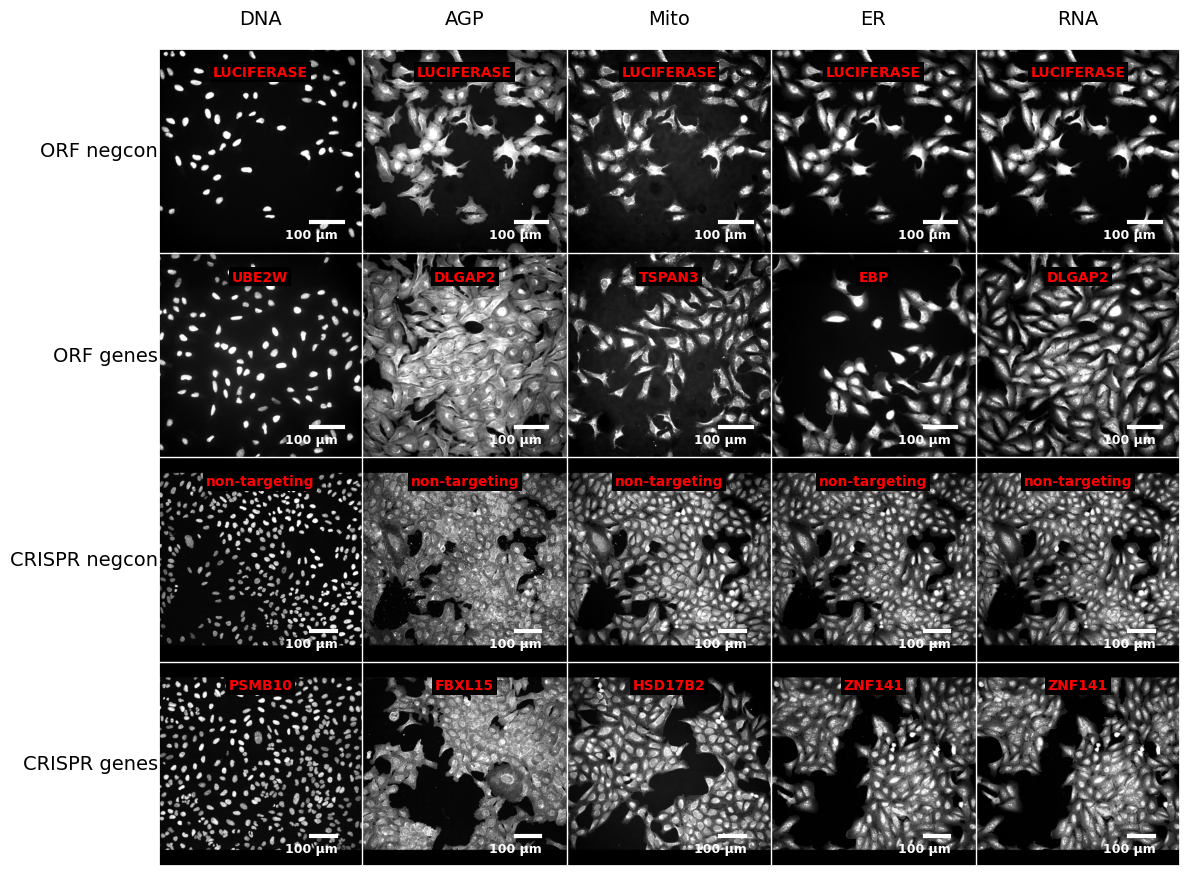

In [27]:
queries = [
    "pert_type == 'negcon' and modality=='ORF'",
    "pert_type == 'trt' and modality=='ORF'",
    "pert_type == 'negcon' and modality=='CRISPR'",
    "pert_type == 'trt' and modality=='CRISPR'",
]

images = []
image_labels = []
scale_bars = []

for query in queries:
    for row in channel_perturbation_df.query(query).itertuples():
        image_labels.append(row.Metadata_Symbol)
        filename = (
            f"images/{row.Metadata_JCP2022}/{row.Metadata_JCP2022}_{row.channel}.tiff"
        )
        img = skimage.io.imread(filename)
        if row.Metadata_Source == "source_4":
            source_4_image_size = 0.5979 * img.shape[1]
        elif row.Metadata_Source == "source_13":
            source_13_image_size = 0.65 * img.shape[1]
        img = utils.brighten_contrast_stretch(img)
        img = utils.standardize_image(img)
        images.append(img)
        if row.Metadata_Source == "source_4":
            scale_bars.append([source_4_image_size, 100])
        elif row.Metadata_Source == "source_13":
            scale_bars.append([source_13_image_size, 100])

row_labels = ["ORF negcon", "ORF genes", "CRISPR negcon", "CRISPR genes"]
col_labels = channels
grid_shape = (4, 5)

fig = utils.create_facet_grid_montage(
    images,
    row_labels,
    col_labels,
    grid_shape,
    image_labels,
    scale_bars = scale_bars,
)

# Save the figure
fig.savefig("figures/facet_grid_montage.png", dpi=300, bbox_inches="tight")
fig.savefig("figures/facet_grid_montage.svg", dpi=300, bbox_inches="tight")

# Display the figure
plt.show()

In [28]:
col_order = [
    "channel",
    "Metadata_JCP2022",
    "Metadata_Symbol",
    "modality",
    "Metadata_Source",
    "Metadata_Batch",
    "Metadata_Plate",
    "Metadata_Well",
]

print(channel_perturbation_df[col_order].to_markdown(index=False))

| channel   | Metadata_JCP2022   | Metadata_Symbol   | modality   | Metadata_Source   | Metadata_Batch    | Metadata_Plate   | Metadata_Well   |
|:----------|:-------------------|:------------------|:-----------|:------------------|:------------------|:-----------------|:----------------|
| DNA       | JCP2022_903350     | UBE2W             | ORF        | source_4          | 2021_05_10_Batch3 | BR00123629       | O08             |
| AGP       | JCP2022_901975     | DLGAP2            | ORF        | source_4          | 2021_06_21_Batch7 | BR00125179       | B07             |
| Mito      | JCP2022_913973     | TSPAN3            | ORF        | source_4          | 2021_06_21_Batch7 | BR00125174       | I15             |
| ER        | JCP2022_902345     | EBP               | ORF        | source_4          | 2021_05_31_Batch2 | BR00123530       | H17             |
| RNA       | JCP2022_901975     | DLGAP2            | ORF        | source_4          | 2021_06_21_Batch7 | BR00125179       | B07